In [1]:
import os
import sys

if os.getcwd().endswith("notebooks"):
    os.chdir("..")

sys.path.append(os.path.abspath("./"))

print(f"Current work directory: {os.getcwd()}")

Current work directory: C:\Users\yyyyx\Work\OC43_machine_learning\Regression_Modeling_of_OC43_Coronavirus_Viral_Burden_from_Host_Single-cell_Transcriptomes_Using_Explainable_Machine_Learning


In [2]:
from sklearn.pipeline import Pipeline
import pandas as pd
from catboost import Pool
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scanpy as sc
import joblib

In [3]:
model = joblib.load('./Data/model/Compact_cat_after_tunning.pkl')

In [4]:
df = pd.read_csv('./CSV/Bulk-seq/GSE252692_converted.csv', index_col='Gene_symbol')

In [5]:
df

,01_uninfected_rep1,02_OC43_3hpi_rep1,03_OC43_6hpi_rep1,04_OC43_9hpi_rep1,05_OC43_12hpi_rep1,06_OC43_18hpi_rep1,07_OC43_24hpi_rep1,08_OC43_30hpi_rep1,17_uninfected_rep3,19_OC43_3hpi_rep3,...,24_OC43_24hpi_rep3,25_OC43_30hpi_rep3,29_uninfected_rep4,31_OC43_3hpi_rep4,32_OC43_6hpi_rep4,33_OC43_9hpi_rep4,34_OC43_12hpi_rep4,35_OC43_18hpi_rep4,36_OC43_24hpi_rep4,37_OC43_30hpi_rep4
Gene_symbol,,,,,,,,,,,,,,,,,,,,,
DDX11L17,25,32,29,19,15,5,7,15,21,16,...,8,2,19,14,24,13,15,10,4,10
PRDM16,386,953,869,609,258,157,128,116,262,360,...,49,56,165,268,307,202,99,105,40,45
PEX10,1490,1638,1287,1063,812,491,498,533,1012,770,...,500,596,1057,834,1173,820,586,643,369,711
RPL23AP21,905,1027,948,825,525,379,494,678,784,450,...,320,675,842,476,717,522,360,380,262,749
RPL21P21,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S,17,4185,44245,1652814,4693716,6899587,6762917,7669257,48,6675,...,4735394,6132980,334,3063,102817,1574640,4262851,7895206,4906336,7356826
ns12.9,1,422,5377,221931,638740,891776,866540,997966,8,778,...,578386,768352,31,297,12588,206909,559854,1020225,633047,943198
E,2,250,3380,143568,424387,547273,534033,614690,7,470,...,336436,446136,17,164,8073,127042,330495,581408,362910,528353


In [6]:
df_t = df.transpose().copy()

In [7]:
df_t.columns.name = 'Samples'

In [8]:
adata = sc.AnnData(df_t.astype(float))
adata.obs_names = df_t.index
adata.var_names = df_t.columns        

adata.var_names_make_unique()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

C:\Users\yyyyx\miniconda3\envs\ml_env\lib\site-packages\anndata\_core\anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [9]:
df_norm_log = pd.DataFrame(
    adata.X,
    index=adata.obs_names,
    columns=adata.var_names
)

In [10]:
num_features = model.feature_names_

use_cols = [c for c in num_features if c in df_norm_log.columns]

df_sub = df_norm_log[use_cols].copy()

In [11]:
y_pred = model.predict(df_sub)

In [12]:
y_pred

array([4.82401841, 4.64712303, 4.73076472, 5.16611612, 5.630785  ,
       5.61799176, 5.89908922, 6.16148206, 4.70330803, 4.7058961 ,
       4.77405911, 5.49444753, 5.61003519, 5.57329354, 6.25570438,
       6.22314376, 4.71414795, 4.74024381, 4.63172574, 5.20976872,
       5.61343627, 5.49903667, 6.26049137, 6.26512162])

In [13]:
df_sub['Prediction'] = y_pred

In [14]:
df_sub['Condition'] = df_sub.index.str.split('_').str[1:-1].str.join('_')

In [15]:
condition_order = [
    'uninfected', 'OC43_3hpi', 'OC43_6hpi', 'OC43_9hpi',
    'OC43_12hpi', 'OC43_18hpi', 'OC43_24hpi', 'OC43_30hpi'
]
df_sub['Condition'] = pd.Categorical(df_sub['Condition'], categories=condition_order, ordered=True)

In [16]:
baseline = df_sub[df_sub['Condition'] == 'uninfected']['Prediction'].mean()

In [17]:
df_sub['Expression_Change'] = df_sub['Prediction'] - baseline

In [18]:
conditions_order = ['uninfected', 'OC43_3hpi', 'OC43_6hpi', 'OC43_9hpi', 
                    'OC43_12hpi', 'OC43_18hpi', 'OC43_24hpi', 'OC43_30hpi']
stats = df_sub.groupby('Condition')['Prediction'].agg(['mean', 'std']).reindex(conditions_order) # Expression Change
means = stats['mean'].values
stds = stats['std'].values

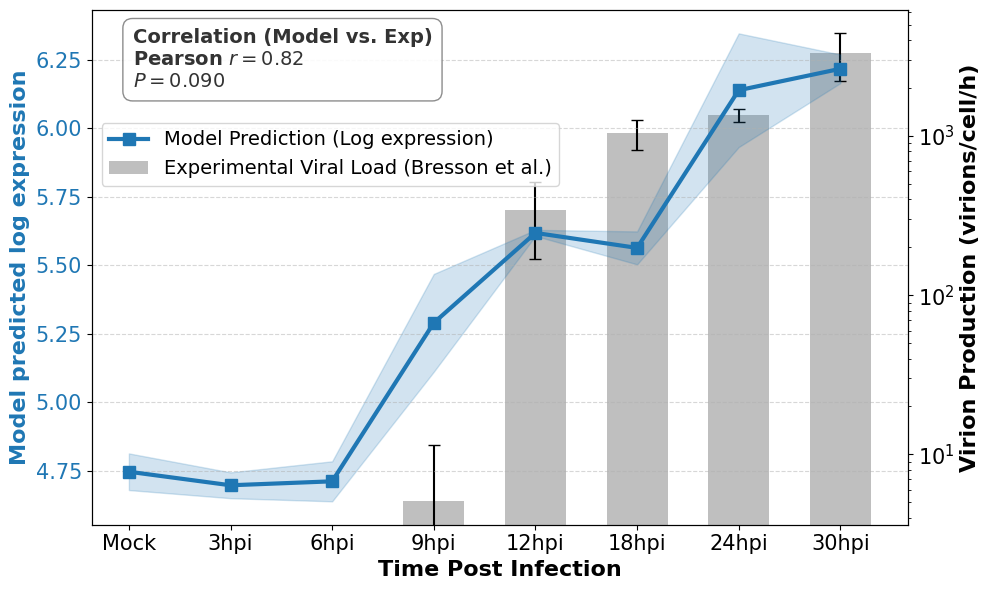

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

# ---------------------------------------------------------
# 1. Data prepare
# ---------------------------------------------------------
means = np.array(means)
stds = np.array(stds)

x_labels_clean = ['Mock', '3hpi', '6hpi', '9hpi', '12hpi', '18hpi', '24hpi', '30hpi']
x_indices = np.arange(len(x_labels_clean))

# [B] Experiment data (Bresson et al.)
exp_means_aligned = np.array([np.nan, np.nan, np.nan, 5.07, 342.58, 1044.38, 1355.27, 3325.20])
exp_sds_aligned   = np.array([np.nan, np.nan, np.nan, 6.40, 173.35, 222.29, 132.04, 1091.65])

# ---------------------------------------------------------
# 2. Statistical correlation
# ---------------------------------------------------------
valid_mask = ~np.isnan(exp_means_aligned)
model_valid = means[valid_mask]
exp_valid_log = np.log10(exp_means_aligned[valid_mask])
r_val, p_val = pearsonr(model_valid, exp_valid_log)

# ---------------------------------------------------------
# 3. Graph
# ---------------------------------------------------------
fig, ax1 = plt.subplots(figsize=(10, 6))

ax2 = ax1.twinx()
color_exp = 'gray'

bars = ax2.bar(x_indices, exp_means_aligned, yerr=exp_sds_aligned,
               color=color_exp, alpha=0.5, width=0.6, 
               capsize=4, error_kw={'ecolor': 'black', 'elinewidth': 1.5},
               label='Experimental Viral Load (Bresson et al.)')

ax2.set_ylabel('Virion Production (virions/cell/h)', color='black', fontsize=16, fontweight='bold')
ax2.set_yscale('log')
ax2.tick_params(axis='y', labelcolor='black', labelsize=15)

ax2.grid(False)

color_model = '#1f77b4'

ax1.plot(x_indices, means, color=color_model, marker='s', markersize=8,
         linewidth=3, label='Model Prediction (Log expression)')

ax1.fill_between(x_indices, means - stds, means + stds, 
                 color=color_model, alpha=0.2, label='Model Prediction SD')

ax1.set_xlabel('Time Post Infection', fontsize=16, fontweight='bold')
ax1.set_ylabel('Model predicted log expression', color=color_model, fontsize=16, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=color_model, labelsize=15)

ax1.set_xticks(x_indices)
ax1.set_xticklabels(x_labels_clean, fontsize=15) 

ax1.grid(True, axis='y', linestyle='--', alpha=0.5)

ax1.set_zorder(ax2.get_zorder() + 1)
ax1.patch.set_visible(False)

if p_val < 0.001:
    p_text = "$P < 0.001$"
else:
    p_text = f"$P = {p_val:.3f}$" 

stats_text = f"Correlation (Model vs. Exp)\nPearson $r = {r_val:.2f}$\n{p_text}"

ax1.text(0.05, 0.85, stats_text, transform=ax1.transAxes, 
         fontsize=14, fontweight='bold', color='#333333',
         bbox=dict(boxstyle="round,pad=0.5", facecolor="white", edgecolor="gray", alpha=0.9))

# --- Legned ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()

ax1.legend([lines_1[0], bars], [labels_1[0], labels_2[0]], 
           loc='upper left', bbox_to_anchor=(0, 0.8), fontsize=14, frameon=True)

plt.tight_layout()
plt.savefig('./Plot/OC43_expression_MRC-5_LargeFont.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

In [20]:
import session_info

session_info.show()